In [11]:
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from IPython import display
from unityagents import UnityEnvironment

from utils import create_next_id_folder
from ddpg_agent_multi import SharedAgent

In [12]:
# Create simulation environment
env = UnityEnvironment(file_name='Reacher_Windows_x86_64_20/Reacher.exe')
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [14]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  7.90150833e+00 -1.00000000e+00
  1.25147629e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -5.22214413e-01]


In [16]:
# load the weights from file
k = 18
models_path = f'ddpg_trials/{k}/'
agent = SharedAgent(state_size=state_size, action_size=action_size, random_seed=0)
agent.actor_local.load_state_dict(torch.load(f'{models_path}actor.pth'))
agent.critic_local.load_state_dict(torch.load(f'{models_path}critic.pth'))

env_info = env.reset(train_mode=False)[brain_name] # reset the environment
states = env_info.vector_observations
scores = np.zeros(num_agents)
agent.reset()

done = False
while not done:

    actions = [agent.act(state) for state in states]           # get actions
    actions = np.clip(actions, -1, 1)
    env_info = env.step(actions)[brain_name]                   # step environment
    next_states = env_info.vector_observations
    rewards = env_info.rewards
    dones = env_info.local_done
    scores += rewards
    states = next_states

    if np.any(dones):
        break

In [4]:
import os
import json
from tqdm import tqdm

for k in range(18, 19):
    # load the weights from file
    models_path = f'ddpg_trials/{k}/'
    agent = SharedAgent(state_size=state_size, action_size=action_size, random_seed=0)
    agent.actor_local.load_state_dict(torch.load(f'{models_path}actor.pth'))
    agent.critic_local.load_state_dict(torch.load(f'{models_path}critic.pth'))
    detailed_scores = []
    mean_scores = []

    num_of_episodes = 100
    for i in tqdm(range(num_of_episodes)):
        env_info = env.reset(train_mode=False)[brain_name] # reset the environment
        states = env_info.vector_observations
        scores = np.zeros(num_agents)
        agent.reset()

        done = False
        while not done:

            actions = [agent.act(state) for state in states]           # get actions
            actions = np.clip(actions, -1, 1)
            env_info = env.step(actions)[brain_name]                   # step environment
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            scores += rewards
            states = next_states

            if np.any(dones):
                break

        detailed_scores.append(list(scores))

        episode_means_score = np.array(scores).mean()
        mean_scores.append(episode_means_score)

    average_score = sum(mean_scores) / len(mean_scores)
    if average_score >= 30.0:
        print(f"PASSED! {models_path} achieved an average of {average_score} in {num_of_episodes} episodes.")
    else:
        print(f"{models_path} achieved an average of {average_score} in {num_of_episodes} episodes.")
    
    with open(os.path.join(f'ddpg_trials/{k}', 'test_scores.json'), 'w') as f:
        json.dump({
            "overall_mean_score": average_score,
            "mean_scores": mean_scores,
            "detailed_scores": detailed_scores,
        }, f, indent=4) # indent makes it human-readable

100%|██████████| 100/100 [5:54:38<00:00, 212.78s/it]  

PASSED! ddpg_trials/18/ achieved an average of 34.93514421913864 in 100 episodes.


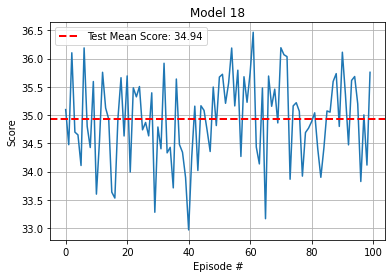

In [5]:
k = 18
fig = plt.figure()
ax = fig.add_subplot(111)
mean_y = np.mean(mean_scores)
plt.plot(np.arange(len(mean_scores)), mean_scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.title(f'Model {k}')
plt.axhline(mean_y, color='red', linestyle='--', linewidth=2, label=f'Test Mean Score: {mean_y:.2f}')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
import os
import json
from tkinter import scrolledtext
import numpy as np
import matplotlib.pyplot as plt
from collections import deque

k = 18
scores_path = os.path.join('ddpg_trials', str(k), "scores.json")
scores = []
with open(scores_path, 'r') as file:
    scores = json.load(file)

scores = np.array(scores)
print(scores.shape)

mean_scores = scores.mean(axis=1)
print(mean_scores.shape)

(500, 20)
(500,)


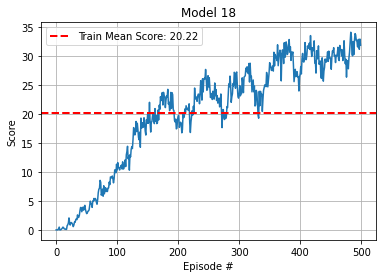

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)

mean_y = np.mean(mean_scores)
plt.plot(np.arange(len(mean_scores)), mean_scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.title(f'Model {k}')
plt.axhline(mean_y, color='red', linestyle='--', linewidth=2, label=f'Train Mean Score: {mean_y:.2f}')
plt.legend()
plt.grid(True)
plt.show()

Environment Solved at Step: 398


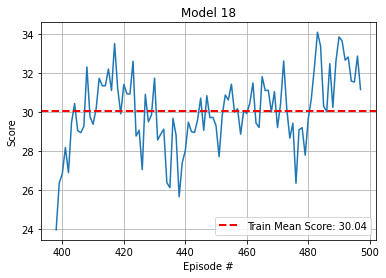

In [12]:
scores_window = deque(maxlen=100)  # last 100 scores

for i, score in enumerate(mean_scores):
    if i >= 100 and np.mean(scores_window) > 30.0:
        print("Environment Solved at Step:", i - 100)
        fig = plt.figure()
        ax = fig.add_subplot(111)
        mean_y = np.mean(scores_window)
        plt.plot(np.arange(i-100, i), scores_window)
        plt.ylabel('Score')
        plt.xlabel('Episode #')
        plt.title(f'Model {k}')
        plt.axhline(mean_y, color='red', linestyle='--', linewidth=2, label=f'Train Mean Score: {mean_y:.2f}')
        plt.legend()
        plt.grid(True)
        plt.show()
        break
    scores_window.append(score)

In [2]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

k = 18
scores_path = os.path.join('ddpg_trials', str(k), "test_scores.json")
scores = []
with open(scores_path, 'r') as file:
    scores = json.load(file)['detailed_scores']

scores = np.array(scores)
print(scores.shape)

mean_scores = scores.mean(axis=1)
print(mean_scores.shape)

mean_score_per_agent = scores.mean(axis=0)
print(mean_score_per_agent.shape)

(100, 20)
(100,)
(20,)


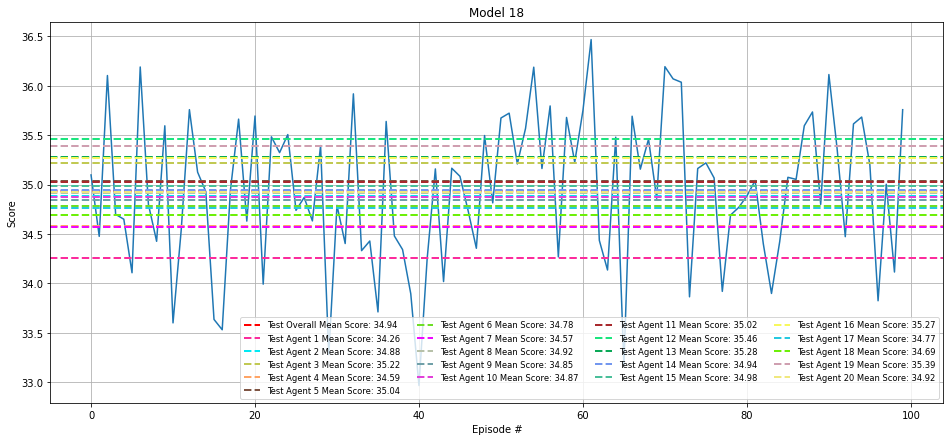

In [10]:
import random

k = 18
fig = plt.figure(figsize=(16,7))
ax = fig.add_subplot(111)
mean_y = np.mean(mean_scores)
plt.plot(np.arange(len(mean_scores)), mean_scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.title(f'Model {k}')
plt.axhline(mean_y, color='red', linestyle='--', linewidth=2, label=f'Test Overall Mean Score: {mean_y:.2f}')

# Function to generate a random hex color
def get_random_hex_color():
    # Generates a random 6-digit hex string
    return '#%06x' % random.randint(0, 0xFFFFFF)


for i, mean in enumerate(list(mean_score_per_agent)):
    plt.axhline(mean, color=get_random_hex_color(), linestyle='--', linewidth=2, label=f'Test Agent {i+1} Mean Score: {mean:.2f}')

plt.legend(loc='best', ncol=4, fontsize='small')
plt.grid(True)
plt.show()